# Import Library yang Diperlukan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import BatchNormalization

# Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv('/content/gym_datasets.csv')

# Tampilkan 10 baris pertama
df.head(10)

,profesi,frekuensi latihan,durasi latihan,tingkat kesibukan,program latihan
0,sekolah,5,60,sedang,"push, pull, leg"
1,karyawan,5,60,sedang,"push, pull, leg"
2,karyawan,3,90,sedang,full body workout
3,mahasiswa,4,75,sedang,upper & lower
4,mahasiswa,2,120,tinggi,full body workout
5,karyawan,5,60,sedang,"push, pull, leg"
6,karyawan,3,90,tinggi,upper & lower
7,karyawan,6,45,rendah,"push, pull, leg"
8,mahasiswa,3,90,tinggi,upper & lower
9,karyawan,6,45,rendah,"push, pull, leg"


In [ ]:
# Cek ukuran awal
print("Ukuran awal:", df.shape)

Ukuran awal: (211, 5)


#Data Preprocessing

## Missing Value

In [ ]:
# Cek missing value
print("\nMissing values per kolom:\n", df.isnull().sum())


Missing values per kolom:
 profesi              0
frekuensi latihan    0
durasi latihan       0
tingkat kesibukan    0
program latihan      0
dtype: int64


## Normalisasi Fitur Numerik

In [ ]:
# Normalisasi kolom numerik
scaler = MinMaxScaler()
numeric_cols = ['frekuensi latihan', 'durasi latihan']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df[numeric_cols].head()

,frekuensi latihan,durasi latihan
0,0.75,0.2
1,0.75,0.2
2,0.25,0.6
3,0.50,0.4
4,0.00,1.0


## Cek Outlier

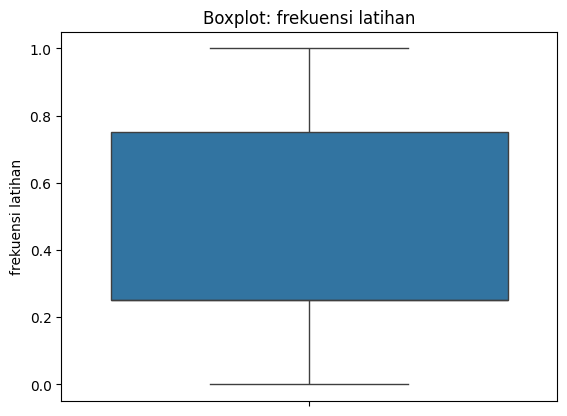

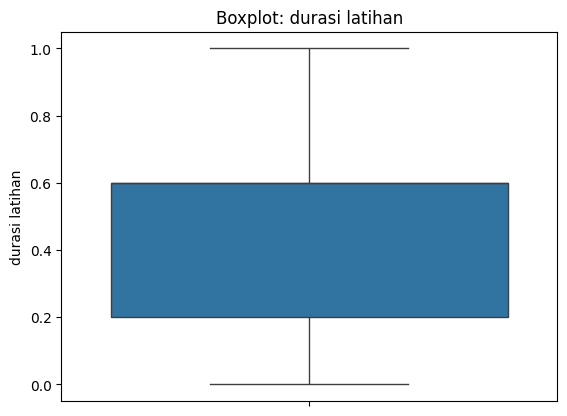

In [ ]:
# Visualisasi boxplot untuk numeric features
for col in numeric_cols:
    sns.boxplot(df[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

In [ ]:
# Tangani outlier dengan metode IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Setelah hapus outlier:", df.shape)

Setelah hapus outlier: (211, 5)


## Analisis Korelasi

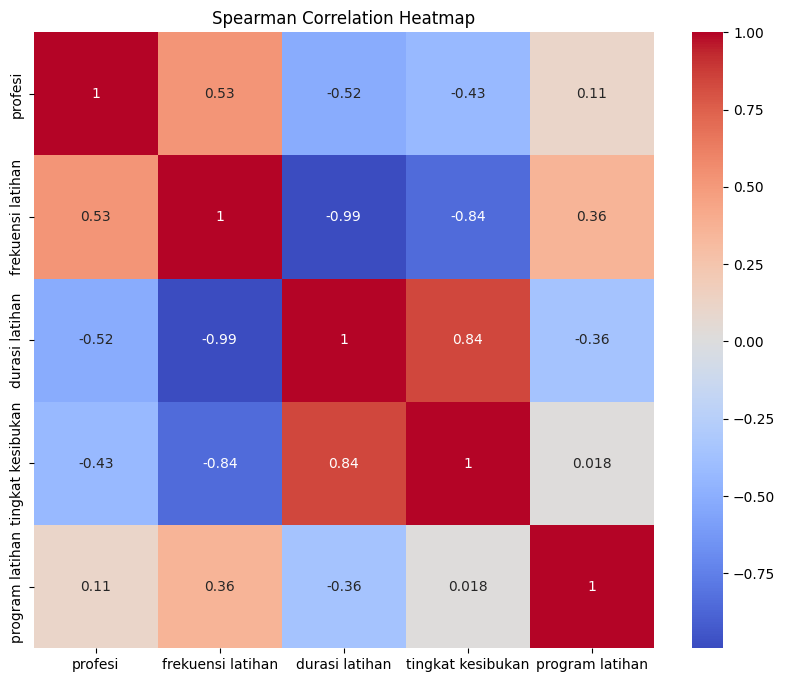

In [ ]:
# Ubah kategorikal jadi angka sementara untuk korelasi
df_temp = df.copy()
le = LabelEncoder()
df_temp['profesi'] = le.fit_transform(df_temp['profesi'])
df_temp['tingkat kesibukan'] = le.fit_transform(df_temp['tingkat kesibukan'])
df_temp['program latihan'] = le.fit_transform(df_temp['program latihan'])

# Korelasi Spearman
correlation = df_temp.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

## Encoding Fitur Kategorikal

In [ ]:
# Encoding
df['profesi'] = le.fit_transform(df['profesi'])  # Label Encoding
df['tingkat kesibukan'] = df['tingkat kesibukan'].map({"rendah": 1, "sedang": 2, "tinggi": 3})
df['program latihan'] = le.fit_transform(df['program latihan'])  # Label encode target

df.head()

,profesi,frekuensi latihan,durasi latihan,tingkat kesibukan,program latihan
0,4,0.75,0.2,2,1
1,2,0.75,0.2,2,1
2,2,0.25,0.6,2,0
3,3,0.50,0.4,2,2
4,3,0.00,1.0,3,0


## Splitting Data

In [ ]:
# Fitur dan target
X = df[['profesi', 'tingkat kesibukan', 'durasi latihan', 'frekuensi latihan']]
y = df['program latihan']

# Split data 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Ukuran data training:", X_train.shape)
print("Ukuran data testing :", X_test.shape)

Ukuran data training: (168, 4)
Ukuran data testing : (43, 4)


# Modelling

##Build Model

In [ ]:
# Cek jumlah kelas
num_classes = len(np.unique(y_train))
num_classes

3

In [ ]:
# Konversi target ke one-hot encoding
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Membangun model
model = Sequential([
    Dense(10, input_dim=4, activation='relu'),
    Dense(6, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Ringkasan arsitektur
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [ ]:
history = model.fit(
    X_train,
    y_train_ohe,
    validation_data=(X_test, y_test_ohe),
    epochs=25,
    batch_size=32,
    verbose=1
)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.3224 - loss: 1.8083 - val_accuracy: 0.3256 - val_loss: 1.1513
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3768 - loss: 1.1055 - val_accuracy: 0.4419 - val_loss: 1.0730
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4717 - loss: 1.0279 - val_accuracy: 0.5349 - val_loss: 0.9690
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5716 - loss: 0.9462 - val_accuracy: 0.6279 - val_loss: 0.9033
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5656 - loss: 0.8812 - val_accuracy: 0.6279 - val_loss: 0.8359
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5884 - loss: 0.8013 - val_accuracy: 0.6279 - val_loss: 0.7963
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6495 - loss: 0.7875 - val_accuracy: 0.6279 - val_loss: 0.7555
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6341 - loss: 0.7362 - val_accuracy: 0.4884 - val_loss: 0.6958

In [ ]:
model.save('mlp_gym_model.h5')

## Visualisasi Antara Akurasi & Loss dengan Validasi

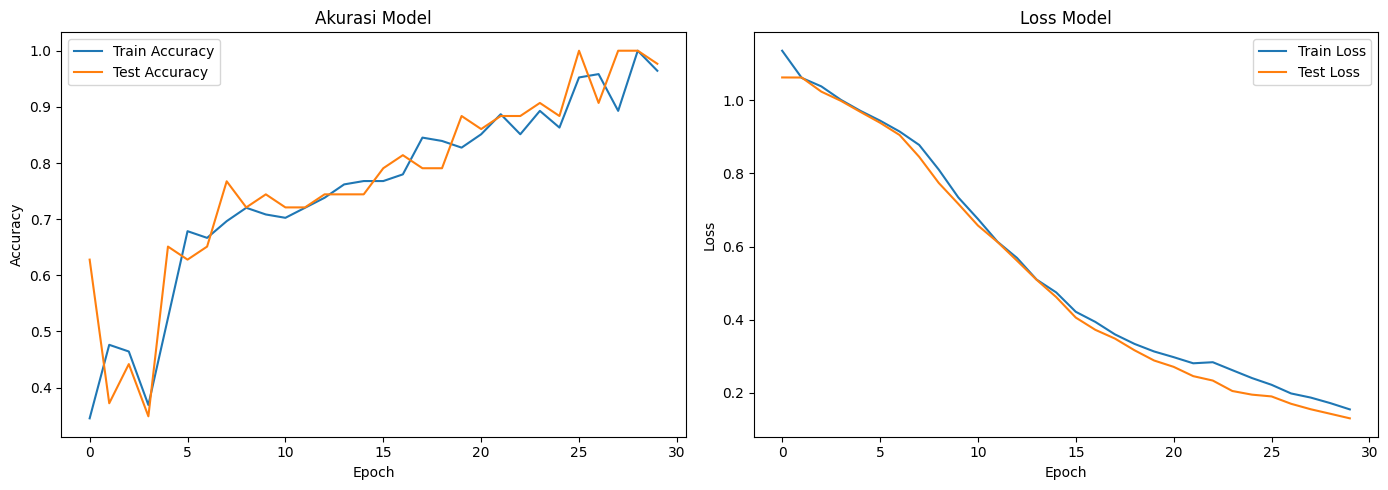

In [ ]:
# Visualisasi akurasi dan loss
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi Model

In [ ]:
# Prediksi probabilitas
y_pred_proba = model.predict(X_test)

# Ambil kelas dengan probabilitas tertinggi
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)  # true label dari one-hot encoding

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


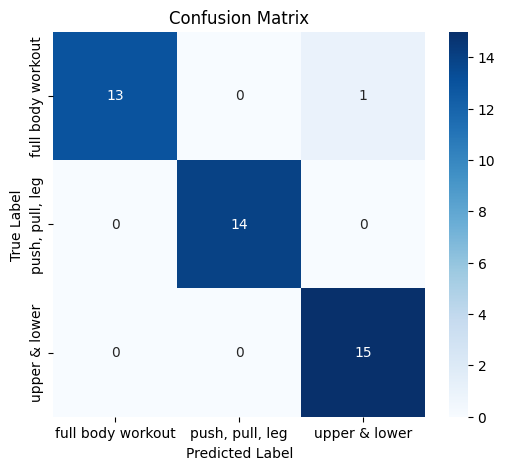

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

                   precision    recall  f1-score   support

full body workout       1.00      0.93      0.96        14
  push, pull, leg       1.00      1.00      1.00        14
    upper & lower       0.94      1.00      0.97        15

         accuracy                           0.98        43
        macro avg       0.98      0.98      0.98        43
     weighted avg       0.98      0.98      0.98        43



## Testing Model

In [ ]:
# Label encoder dan mapping (sama kayak waktu training!)
profesi_list = ['sekolah', 'mahasiswa', 'karyawan', 'ibu rumah tangga', 'pns']
label_encoder = LabelEncoder()
label_encoder.fit(['push, pull, leg', 'upper & lower', 'full body workout'])

kesibukan_mapping = {"rendah": 1, "sedang": 2, "tinggi": 3}
scaler = MinMaxScaler()

In [ ]:
# Normalisasi manual - nilai referensi dari training set
durasi_min = 30 # sesuaikan ini
durasi_max = 120
frekuensi_min = 1
frekuensi_max = 7

# ========== Input User ==========
print("===== PREDIKSI PROGRAM LATIHAN =====")

profesi_input = input(f"Profesi (pilih salah satu dari {profesi_list}): ").strip().lower()
kesibukan_input = input("Tingkat Kesibukan (rendah/sedang/tinggi): ").strip().lower()
frekuensi_input = int(input("Frekuensi Latihan per minggu (contoh: 3): "))
durasi_input = int(input("Durasi Latihan (dalam menit, contoh: 60): "))

# ========== Preprocessing ==========
# Profesi di-encode manual
profesi_kode = profesi_list.index(profesi_input) if profesi_input in profesi_list else 0
kesibukan_kode = kesibukan_mapping.get(kesibukan_input, 2)

# Normalisasi
frekuensi_norm = (frekuensi_input - frekuensi_min) / (frekuensi_max - frekuensi_min)
durasi_norm = (durasi_input - durasi_min) / (durasi_max - durasi_min)

# Susun fitur input (harus dalam urutan input training!)
X_test_input = np.array([[profesi_kode, kesibukan_kode, durasi_norm, frekuensi_norm]])

# ========== Prediksi ==========
pred_proba = model.predict(X_test_input)
pred_label = np.argmax(pred_proba)
program_latihan = label_encoder.inverse_transform([pred_label])[0]

# ========== Output ==========
print("\n======= HASIL REKOMENDASI =======")
print(f"Program latihan yang direkomendasikan: **{program_latihan.upper()}**")
print("Probabilitas per kelas:")
for i, prob in enumerate(pred_proba[0]):
    print(f"{label_encoder.inverse_transform([i])[0]}: {prob:.4f}")

===== PREDIKSI PROGRAM LATIHAN =====
Profesi (pilih salah satu dari ['sekolah', 'mahasiswa', 'karyawan', 'ibu rumah tangga', 'pns']): mahasiswa
Tingkat Kesibukan (rendah/sedang/tinggi): sedang
Frekuensi Latihan per minggu (contoh: 3): 4
Durasi Latihan (dalam menit, contoh: 60): 75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

======= HASIL REKOMENDASI =======
Program latihan yang direkomendasikan: **UPPER & LOWER**
Probabilitas per kelas:
full body workout: 0.0527
push, pull, leg: 0.0167
upper & lower: 0.9305
